In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [93]:
%matplotlib inline

In [94]:
train_df = pd.read_csv("../data/train.csv")
train_df.shape

(30471, 292)

292 features here

In [95]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


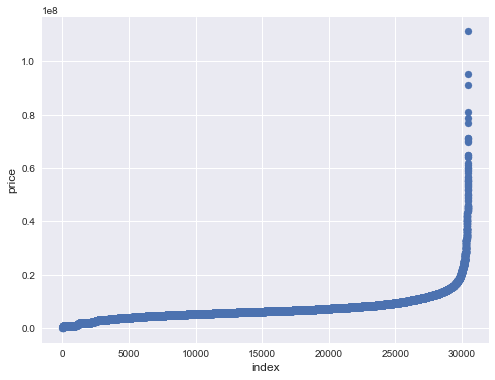

In [96]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

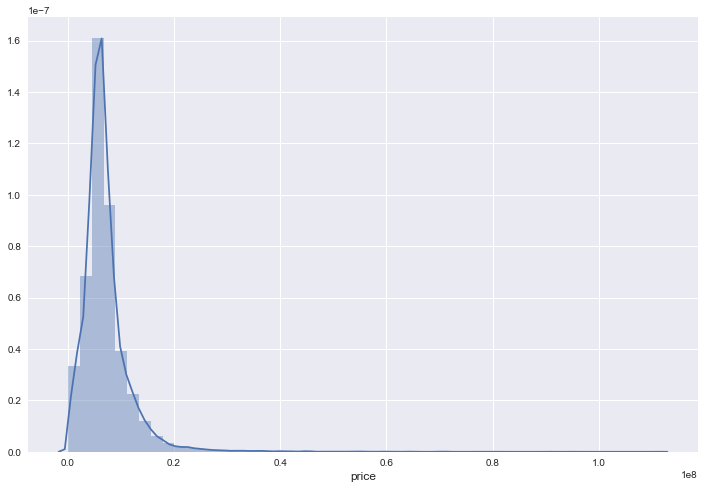

In [97]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

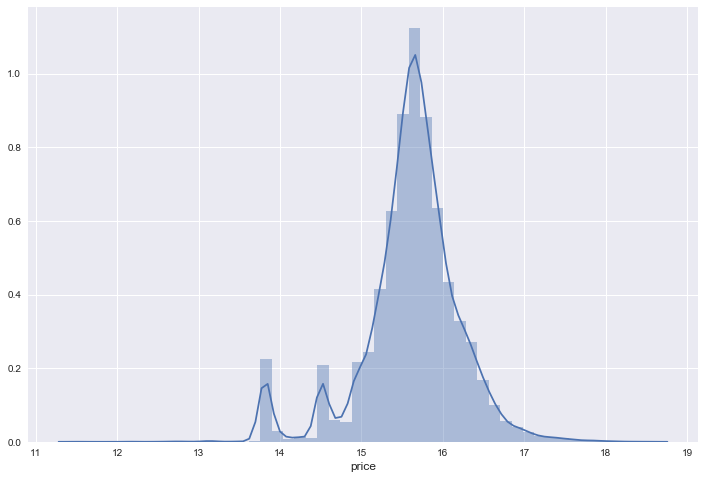

In [98]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [99]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4]+x[5:7])
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

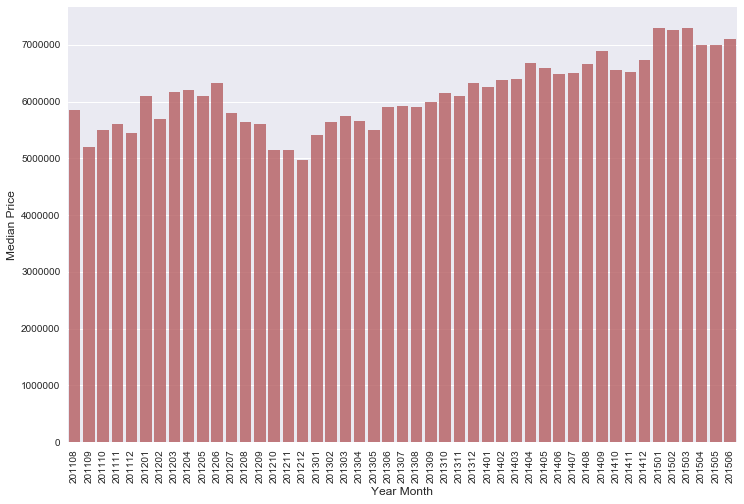

In [100]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [101]:
train_df.get_dtype_counts()

float64    119
int64      157
object      17
dtype: int64

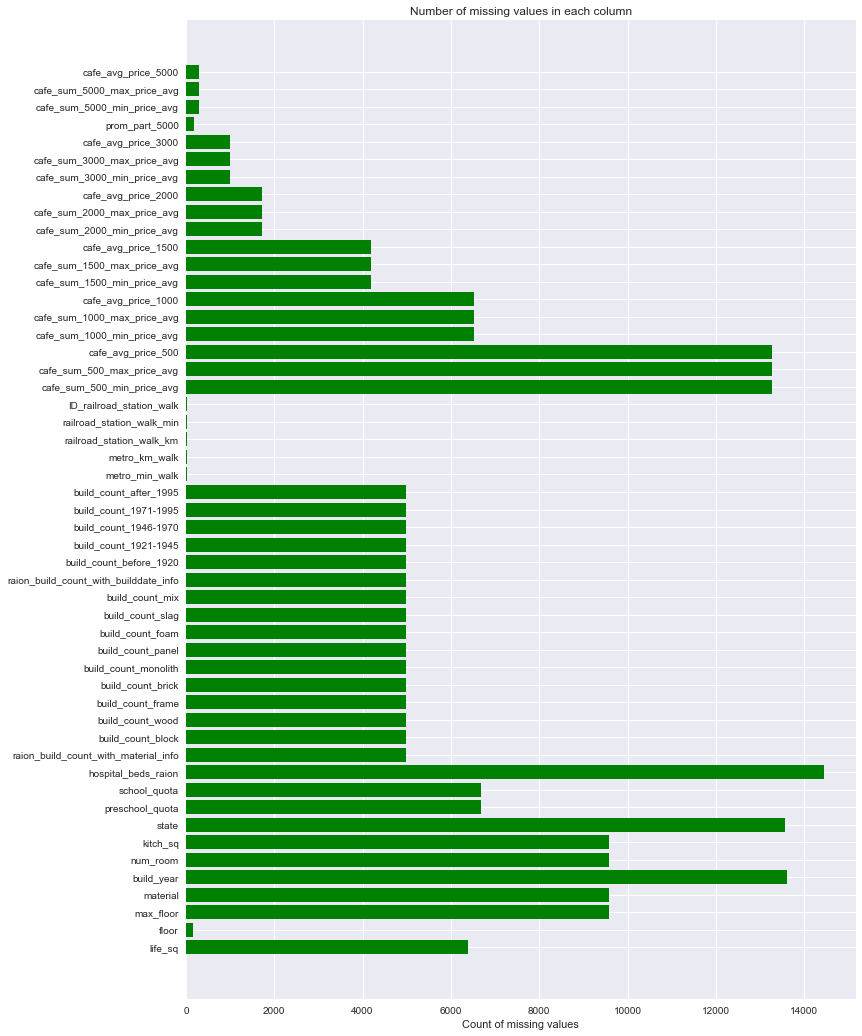

In [102]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='green')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

The other simple exploration notebook uses xgboost to find top 5 most important features.
They come up with:
1. full_sq
2. life_sq
3. floor
4. max_floor
5. build_year

Considering 'life_sq', 'max_floor', and 'build_year' have a lot of missing values, I question their use.  I also suspect that the other notebook's importance model does not take into account the missing values and weights the features more heavily as a result.  But I'll proceed with the plots anyway, for now.

**Total area, full_sq**

C:\Users\Ben\Anaconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


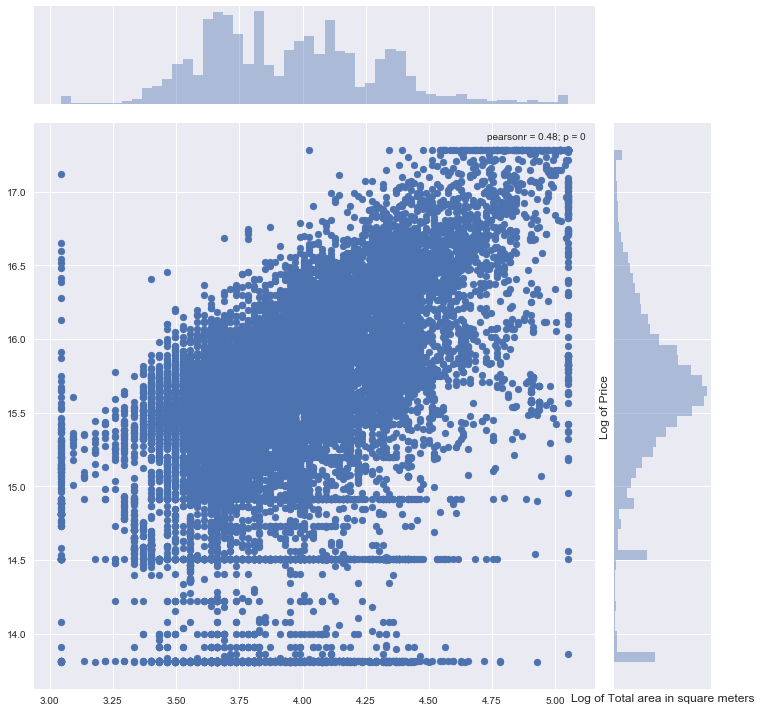

In [103]:
ulimit = np.percentile(train_df.price_doc.values, 99.5)
llimit = np.percentile(train_df.price_doc.values, 0.5)
train_df['price_doc'].loc[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].loc[train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square meters', fontsize=12)
plt.show()

**Living area, life_sq**

C:\Users\Ben\Anaconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


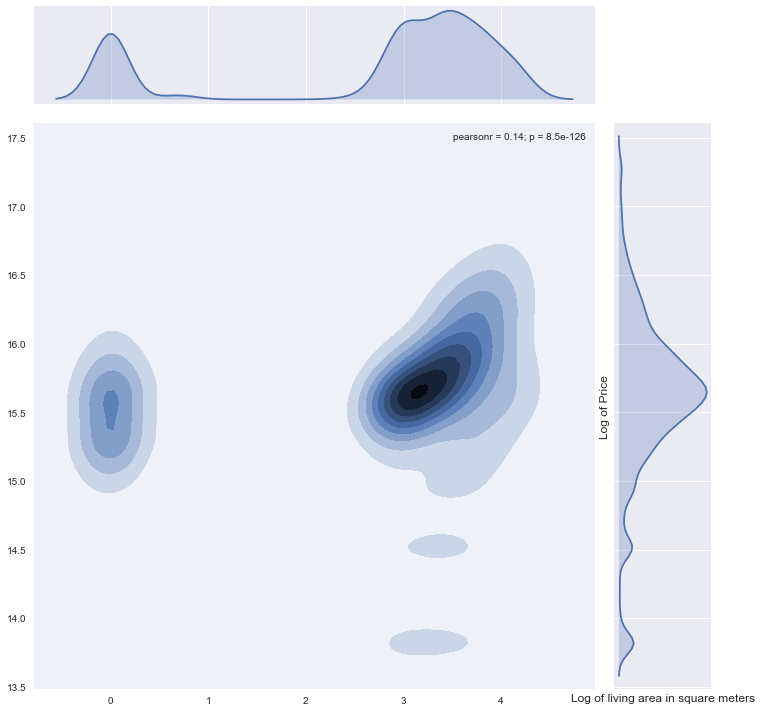

In [104]:
col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y=np.log1p(train_df.price_doc.values), 
              kind='kde', size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square meters', fontsize=12)
plt.show()

**Floor**, count plot

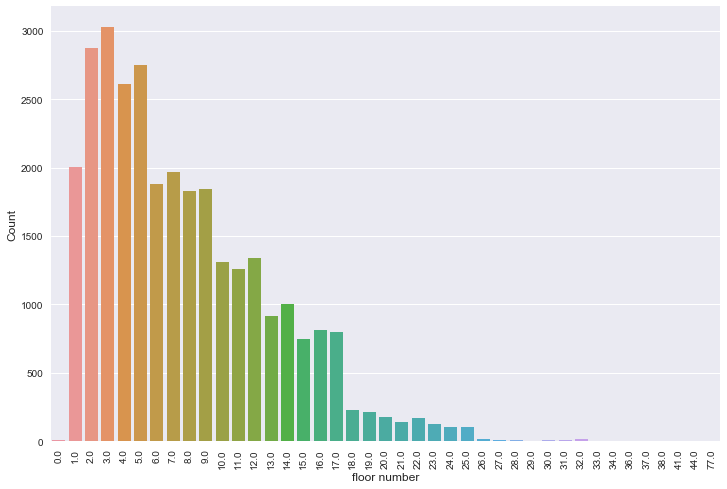

In [105]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

**Floors**, vs price

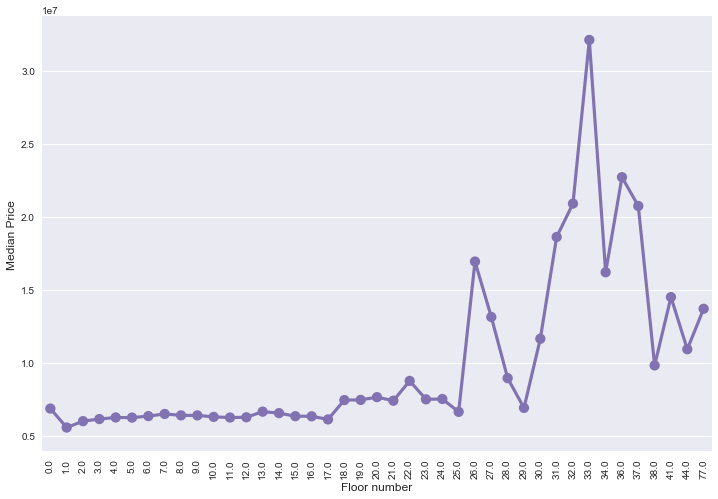

In [106]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[3])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

As the other notebook mentions, a higher floor yields a higher price.  Additionally, there is a slight premium for "single family homes".

**Max floor**, counts

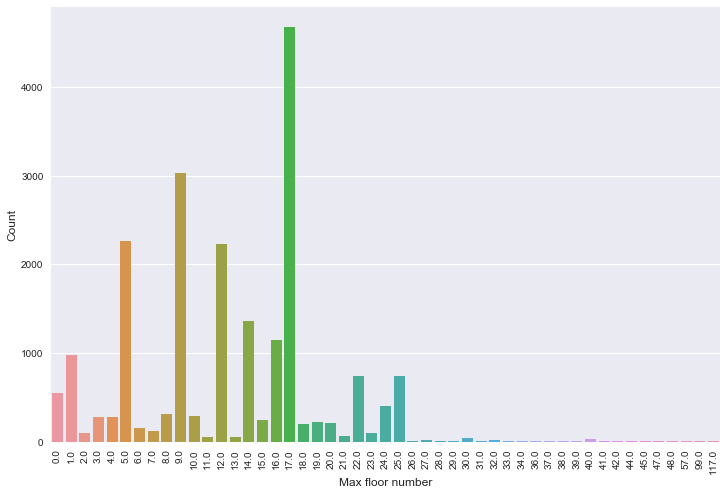

In [107]:
plt.figure(figsize=(12,8))
sns.countplot(x="max_floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

**Max floor**, vs price

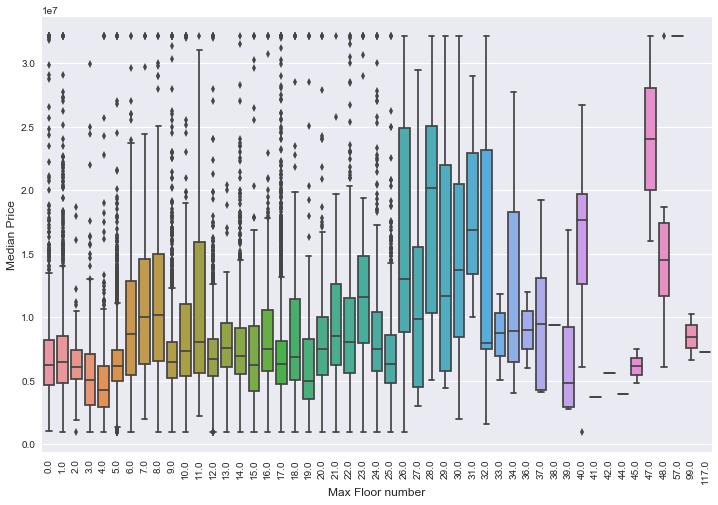

In [108]:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### A simple linear regression model on one feature

In [126]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from math import sqrt

In [110]:
# Identify target and one feature
price = train_df.price_doc.values
full_sq = train_df.full_sq.values

In [111]:
# Split into training set and validation set
full_sq_train, full_sq_valid, price_train, price_valid = train_test_split(full_sq, price, test_size=.3, random_state=42)

In [112]:
type(full_sq_valid)

numpy.ndarray

In [113]:
# Investigate target and feature
print(price_valid.shape, len(pd.notnull(price_valid)), pd.DataFrame(price_valid).get_dtype_counts())
print(full_sq_valid.shape, len(pd.notnull(full_sq_valid)), pd.DataFrame(full_sq_valid).get_dtype_counts())

(9142,) 9142 float64    1
dtype: int64
(9142,) 9142 float64    1
dtype: int64


In [114]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [115]:
# Train the model using target and single feature - adding the reshape because fit expects a 2D array, and train_sq is 1D
regr.fit(full_sq_train.reshape(len(full_sq_train), 1), price_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [ 127385.60865443]


In [125]:
full_sq_valid = full_sq_valid.reshape(len(full_sq_valid), 1)
predictions = regr.predict(full_sq_valid)

In [118]:
# The mean squared error
print("Mean squared error: %.2f" % np.mean((predictions - price_valid) ** 2))

Mean squared error: 10752882754503.76


In [119]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(full_sq_valid, price_valid))

Variance score: 0.39


In [120]:
# RSS
print("Residual Sum of Squares: %.2f" % np.sum(predictions - price_valid))

Residual Sum of Squares: 31774312.43


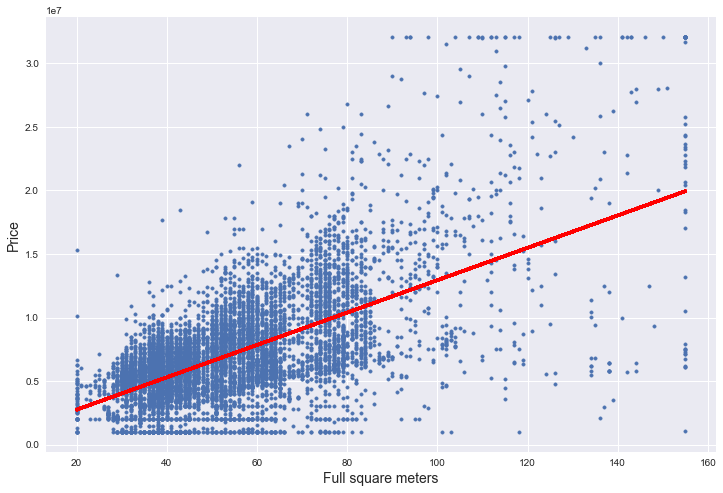

In [122]:
# Plot outputs
plt.figure(figsize=(12,8))
plt.scatter(full_sq_valid, price_valid, marker=".")
plt.plot(full_sq_valid, predictions, color='red', linewidth=3)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Full square meters', fontsize=14)
plt.xticks()
plt.yticks()
plt.show()

In [128]:
# Root Mean Squared Logarithmic Error, RMSLE
def rmsle(num_observations, predictions, actual_value):
    epsilon = sqrt((sum((np.log(predictions + 1) - np.log(actual_value + 1)) ** 2)) / num_observations)
    return epsilon

In [129]:
rmsle(num_observations=len(predictions), predictions=predictions, actual_value=price_valid)

0.5329055919114738